# Blog Metadata

This blog describes the TACTiS model for probabilistic time series prediction as introduced in our papers [TACTiS: Transformer-Attentional Copulas for Time Series](https://arxiv.org/abs/2202.03528) and [TACTiS-2: Better, Faster, Simpler Attentional Copulas for Multivariate Time Series](https://arxiv.org/abs/2310.01327).

## Introduction

Time is money, and forecasting is power. By analyzing past patterns and trends, you can predict the future with confidence and accuracy. Time series forecasting can help you make optimal and informed decisions, whether you want to grow your revenue, balance your supply and demand, or adapt to the changing environment.

In numerous time series forecasting contexts, data presents itself in a raw form that rarely matches the standard assumptions of classical forecasting methods. For instance, in healthcare settings and economic forecasting, groups of related time series can have different sampling frequencies, be sampled irregularly, and exhibit missing values. Further, covariates that complement the data and are predictive of future behavior may not be available for all historical data, or may be available in a different form, e.g., due to changes in measurement methodology.

We seek to develop general-purpose models that can handle several stylized facts of real-world time series problems, namely 
* a large number of time series
* arbitrarily complex data distributions
* heterogeneous or irregular sampling frequencies
* missing data
* the availability of deterministic covariates for conditioning (e.g., holiday indicators)
* being flexible enough to handle a variety of tasks, such as forecasting, interpolation, imputation and their combinations

## The TACTiS model

We introduce TACTiS, a Transformer-based model for multivariate probabilistic time series prediction, that can handle all the above stylized facts of real-world time series.

The TACTiS model infers the **joint distribution of masked time points given observed time points in multivariate time series**. It enables **probabilistic multivariate forecasting, interpolation, and arbitrary combinations of these tasks** according to arbitrary masking patterns.

In Section 1 of this blog, we will see how to use the TACTiS model in practice.


If you are interested in the deeper details of the TACTiS model, such as how it achieves a high level of flexibility and how it models forecast distributions, please go to Section 2 of this blog.

# Section 1

## Example 1: Forecasting and Interpolation on a random walk dataset

In this section, we will first explain step-by-step how TACTiS can be used to perform forecasting and interpolation tasks in a stochastic process. Later, we will explain how to use TACTiS with forecasting and interpolation tasks based on real-world datasets.

**Note**: We recommend using a separate `conda` environment with the Python version >= `3.10.8` for the following cells. To create a conda environment, please execute the following commands (you may have to restart your notebook after you create the environment, for the changes to come in effect)

Create the conda environment. You may have to restart your shell after this.
```
conda create --name tactis_env --python 3.10.8
```
Activate the conda environment
```
conda activate tactis_env
```

We will first install the [tactis](https://pypi.org/project/tactis/) library using [pypi](https://pypi.org/).

In [1]:
!pip install tactis

Now, we import the required depenedencies.

In [17]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math

from tactis.model.tactis import TACTiS

We set the device in which we will run our model. Set this to `torch.device("cpu")` if you do not have a GPU. If you have a CUDA-enabled GPU, you can set it to `torch.device("cuda")`. 

In [6]:
device = torch.device("cpu")

We now define the data. For this blog, we use a random walk dataset, which is a series randomly sampled from the Normal distribution that forces dependence from one-time step to the next. A random walk is different from a list of random numbers because the next value in the sequence is a modification of the previous value in the sequence. For this example, we use a random walk with 10 different series.

Note that this example is only used as a sanity check to verify that our model works. If you're interested in working with real-world time series, we recommend you check Example 2.

In [7]:
def generate_random_data():
    np.random.seed(12345)
    
    # Our dataset consists of 100000 samples and 10 series
    n = 100000
    p = 10

    # The cumsum forces the dependency from one timestep to the next
    X = np.cumsum(np.random.randn(p, n), axis=1)

    # We partition our data into train and test sets arbitrary
    X_train = X[:, : n//2]
    X_test = X[:, n//2 :]
    
    return X_train, X_test

We visualize the data for our reference.

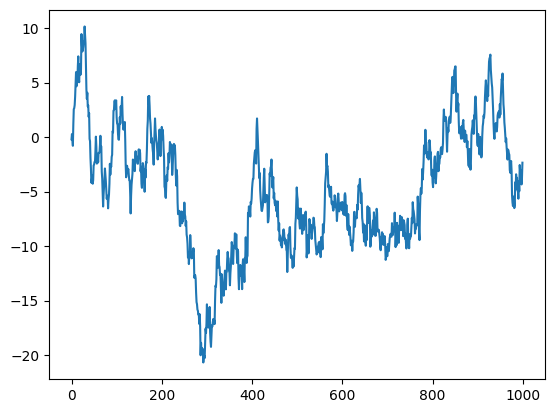

In [8]:
data_train, data_test = generate_random_data()

plt.plot(data_train[0, :1000])
plt.show()

We define the TACTiS-2 model here. We use arbitrary hyperparameters for the example. For your specific dataset, it is recommended to perform a hyperparameter search to maximize performance.

In [9]:
def create_net():
    net = TACTiS(
        num_series=10,
        flow_series_embedding_dim=5,
        copula_series_embedding_dim=5,
        flow_input_encoder_layers=3,
        copula_input_encoder_layers=3,
        input_encoding_normalization=True,
        data_normalization="standardization",
        loss_normalization="series",
        positional_encoding={
            "dropout": 0.0,
        },
        flow_temporal_encoder={
            "attention_layers": 3,
            "attention_heads": 3,
            "attention_dim": 16,
            "attention_feedforward_dim": 16,
            "dropout": 0.0,
        },
        copula_temporal_encoder={
            "attention_layers": 3,
            "attention_heads": 3,
            "attention_dim": 16,
            "attention_feedforward_dim": 16,
            "dropout": 0.0,
        },
        copula_decoder={
            "min_u": 0.01,
            "max_u": 0.99,
            "attentional_copula": {
                "attention_heads": 3,
                "attention_layers": 3,
                "attention_dim": 16,
                "mlp_layers": 3,
                "mlp_dim": 16,
                "resolution": 50,
            },
            "dsf_marginal": {
                "mlp_layers": 2,
                "mlp_dim": 8,
                "flow_layers": 2,
                "flow_hid_dim": 8,
            },
        },
    )
    return net.to(device)

Define the training loop. This consists of sampling windows from our time series, passing it through the model and minimizing its loss function.

In [23]:
def switch_to_stage2(net):
    """This function allows the TACTiS-2 model to switch to stage 2 of training"""
    net.set_stage(2)
    net.initialize_stage2()
    net.to(device)
    
    parameter_names_to_optimize = [
        "copula_series_encoder",
        "copula_time_encoding",
        "copula_input_encoder",
        "copula_encoder",
        "decoder.copula",
    ]
    params_to_optimize_in_stage2 = []
    for name, param in net.named_parameters():
        if any(pname in name for pname in parameter_names_to_optimize):
            params_to_optimize_in_stage2.append(param)
    optimizer = torch.optim.RMSprop(params_to_optimize_in_stage2, lr=1e-4, weight_decay=0)
    return net, optimizer

def step(net, optimizer, batch_size, data, hist_length, pred_length, phase=1):
    """Training loop"""
    max_idx = data.shape[1] - (hist_length + pred_length)
    
    hist_values = []
    pred_values = []
    for _ in range(batch_size):
        idx = np.random.randint(0, max_idx)
        hist_values.append(data[:, idx:idx+hist_length])
        pred_values.append(data[:, idx+hist_length:idx+hist_length+pred_length])
    
    # [batch, series, time steps]
    hist_value = torch.Tensor(hist_values).to(device)
    pred_value = torch.Tensor(pred_values).to(device)
    hist_time = torch.arange(0, hist_length, device=device)[None, :].expand(batch_size, -1)
    pred_time = torch.arange(hist_length, hist_length + pred_length, device=device)[None, :].expand(batch_size, -1)
    
    optimizer.zero_grad()
    _ = net.loss(hist_time, hist_value, pred_time, pred_value)
    
    marginal_logdet, copula_loss = (
        net.marginal_logdet,
        net.copula_loss,
    )
    if phase == 1:
        loss = -marginal_logdet
    else:
        loss = copula_loss
    loss_avg = loss.mean()
    loss_avg.backward()
    optimizer.step()
    
    unweighted_loss = -marginal_logdet + copula_loss

    return unweighted_loss.mean().item()

Create the network and its optimizer.

In [28]:
net = create_net()
optimizer = torch.optim.RMSprop(net.parameters(), lr=1e-3, weight_decay=0)

Train the model. We are using the latest TACTiS-2 model that trains in two phases.

In [29]:
avg_loss = []

# Set an arbitrary number of epochs. 
# For your dataset, you will have to set an appropriate number of epochs for convergence.
# We recommend using early stopping with an appropriate patience and precision.
NUM_EPOCHS_STAGE_1 = 20
NUM_EPOCHS_STAGE_2 = 100

# Number of batches in an epoch; should be large enough depending on the size of the dataset
NUM_BATCHES = 100

# Batch size
BATCH_SIZE = 256

# We use history and prediction lengths of 10 for this example
HIST_LENGTH = 10
PRED_LENGTH = 10

# Training loop

PHASE = 1
print("Phase:", PHASE)

for epoch in range(NUM_EPOCHS_STAGE_1):
    running_sum = 0
    for batch in range(NUM_BATCHES):
        running_sum += step(net, optimizer, BATCH_SIZE, data_train, HIST_LENGTH, PRED_LENGTH, phase=PHASE)
    avg_loss.append(running_sum / NUM_BATCHES)
    print("Epoch:", epoch, "Average Loss:", avg_loss[-1])

net, optimizer = switch_to_stage2(net)

PHASE = 2
print("Phase:", PHASE)

for epoch in range(NUM_EPOCHS_STAGE_2):
    running_sum = 0
    for batch in range(NUM_BATCHES):
        running_sum += step(net, optimizer, BATCH_SIZE, data_train, HIST_LENGTH, PRED_LENGTH, phase=PHASE)
    avg_loss.append(running_sum / NUM_BATCHES)
    print("Epoch:", NUM_EPOCHS_STAGE_1+epoch, "Average Loss:", avg_loss[-1])

Phase: 1
Epoch: 0 Average Loss: 23.165807037353517
Epoch: 1 Average Loss: 21.45296817779541
Epoch: 2 Average Loss: 21.210927848815917
Epoch: 3 Average Loss: 21.12000286102295
Epoch: 4 Average Loss: 21.10337965011597
Epoch: 5 Average Loss: 21.03964298248291
Epoch: 6 Average Loss: 21.03188772201538
Epoch: 7 Average Loss: 21.027397212982176
Epoch: 8 Average Loss: 21.040210666656495
Epoch: 9 Average Loss: 21.004604530334472
Epoch: 10 Average Loss: 21.017290897369385
Epoch: 11 Average Loss: 21.008802280426025
Epoch: 12 Average Loss: 21.00419059753418
Epoch: 13 Average Loss: 21.01800132751465
Epoch: 14 Average Loss: 21.00382345199585
Epoch: 15 Average Loss: 20.97228992462158
Epoch: 16 Average Loss: 20.9992352104187
Epoch: 17 Average Loss: 20.95589059829712
Epoch: 18 Average Loss: 20.979221801757813
Epoch: 19 Average Loss: 20.9859069442749
Phase: 2
Epoch: 20 Average Loss: 21.041013488769533
Epoch: 21 Average Loss: 21.015831661224365
Epoch: 22 Average Loss: 20.99565851211548
Epoch: 23 Average 

Visualize the loss

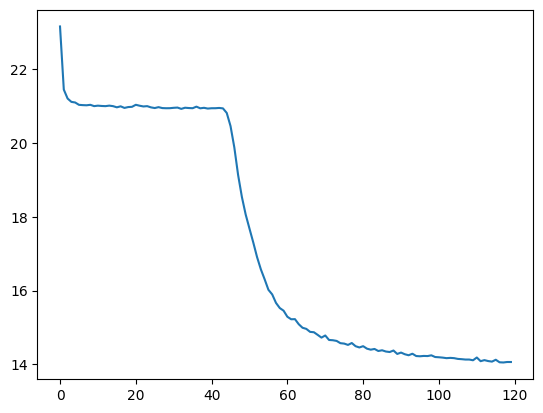

In [30]:
plt.figure()
plt.plot(avg_loss)

Define the sampling function of the model. Given a context window from the test set of size `HIST_LENGTH`, perform prediction for `PRED_LENGTH` next timesteps. 
In theory, TACTiS can consume a context window of any length and predict for any length at inference.
We have used both as `10` in this example, so we use the same during inference. 


In [31]:
def sample(net, num_samples, data, hist_length, pred_length):
    max_idx = data.shape[1] - (hist_length + pred_length)
    
    idx = np.random.randint(0, max_idx)
    hist_value = torch.Tensor(data[:, idx:idx+hist_length]).to(device)
    pred_value = torch.Tensor(data[:, idx+hist_length:idx+hist_length+pred_length]).to(device)
    
    # [batch, series, time steps]
    hist_value = hist_value[None, :, :]
    pred_value = pred_value[None, :, :]
    hist_time = torch.arange(0, hist_length, device=device)[None, :]
    pred_time = torch.arange(hist_length, hist_length + pred_length, device=device)[None, :]

    samples = net.sample(num_samples, hist_time, hist_value, pred_time)
    
    return samples, torch.cat([hist_value, pred_value], axis=2), torch.cat([hist_time, pred_time], axis=1)

Obtain the predicted samples for the given prediction window.

In [32]:
samples, pred_value, timesteps = sample(net, 1000, data_test, HIST_LENGTH, PRED_LENGTH)

Visualize the samples. We first define a helper function to plot the given context and predicted forecasts.

In [33]:
def plot_single_series(samples, target, timesteps, index):
    s_samples = samples[0, index, :, :].cpu().numpy()
    s_timesteps = timesteps[0, :].cpu().numpy()
    s_target = target[0, index, :].cpu().numpy()
    
    plt.figure()
    
    for zorder, quant, color, label in [
        [1, 0.05, (0.75,0.75,1), "5%-95%"],
        [2, 0.10, (0.25,0.25,1), "10%-90%"],
        [3, 0.25, (0,0,0.75), "25%-75%"],
    ]:
        plt.fill_between(
            s_timesteps,
            np.quantile(s_samples, quant, axis=1),
            np.quantile(s_samples, 1 - quant, axis=1),
            facecolor=color,
            interpolate=True,
            label=label,
            zorder=zorder,
        )
    
    plt.plot(
        s_timesteps,
        np.quantile(s_samples, 0.5, axis=1),
        color=(0.5,0.5,0.5),
        linewidth=3,
        label="50%",
        zorder=4,
    )
    
    plt.plot(s_timesteps, s_target, color=(0, 0, 0), linewidth=2, zorder=5, label="ground truth")
    
    handles, labels = plt.gca().get_legend_handles_labels()
    order = [1, 2, 3, 4, 0]
    plt.legend([handles[idx] for idx in order], [labels[idx] for idx in order])
    
    plt.show()

Plot the samples.

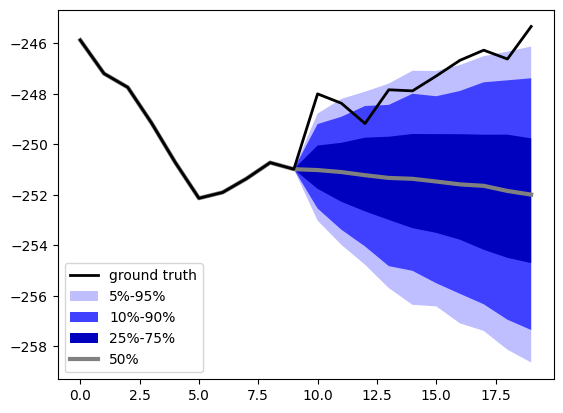

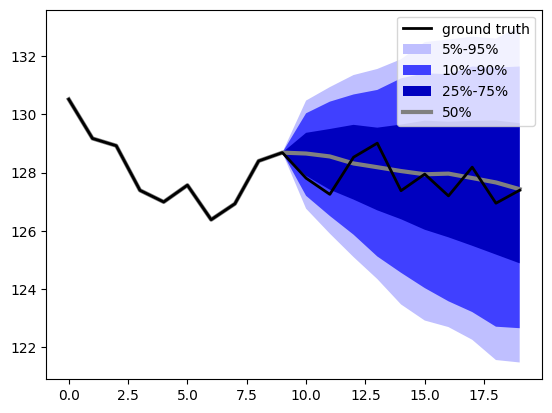

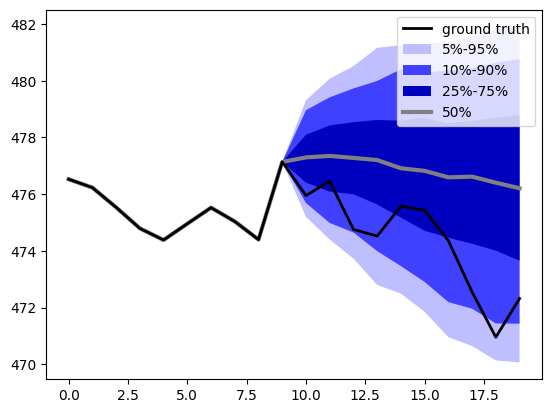

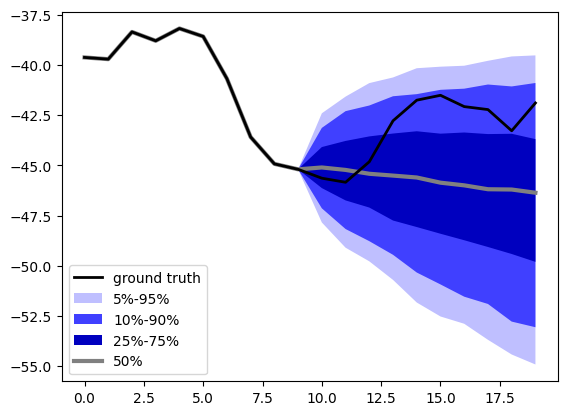

In [34]:
for i in range(4):
    plot_single_series(samples, pred_value, timesteps, i)

Visualize the instantaneous correlations learned by the model. 

As per the definition of our data, the correlations should increase as we go to later time steps, especially for close time steps. This is visible in the plot below.

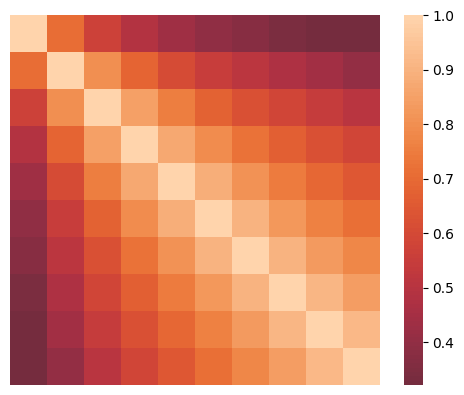

In [35]:
corrcoef = 0
for b in range(samples.shape[0]):
    for v in range(samples.shape[1]):
        spl = samples[b,v,HIST_LENGTH:,:].cpu().numpy()
        corrcoef = corrcoef + np.corrcoef(spl)
corrcoef /= (samples.shape[0] * samples.shape[1])

plt.figure()

svm = sns.heatmap(corrcoef, robust=True, center=0, xticklabels=False, yticklabels=False)
plt.gca().set_aspect('equal', 'box')
plt.show()

## Example 2: Forecasting and Interpolation on real-world datasets

This is an example of how one can perform forecasting and interpolation tasks on real-world data.

In this example, we use the [GluonTS](https://github.com/awslabs/gluonts) library to process the dataset for training and validation, and to evaluate our model and obtain metrics. We use [PyTorchTS](https://github.com/zalandoresearch/pytorch-ts/tree/master) to sample data windows for training and evaluation.

To use GluonTS and PyTorchTS, the `research` version of the `tactis` library has to be installed. This can be done using `pip install tactis[research]` as below.

In [ ]:
!pip install tactis[research]

We use the [FRED-MD](https://zenodo.org/records/4654833) dataset for our example. This dataset contains 107 monthly time series showing a set of macro-economic indicators from the Federal Reserve Bank. It was extracted from the [FRED database](https://fred.stlouisfed.org/). The series are differenced and log-transformed as suggested in the literature.

The `tactis` package already contains helper functions to use datasets that are available in the GluonTS library. We first define the date ranges used for training, validation and testing.

In [4]:
import torch
import pandas as pd
from tactis.gluon.estimator import TACTiSEstimator
from tactis.gluon.trainer import TACTISTrainer
from tactis.gluon.dataset import _load_raw_dataset, _count_timesteps, __FixedMultivariateGrouper
from tactis.gluon.metrics import compute_validation_metrics, compute_validation_metrics_interpolation
from tactis.gluon.plots import plot_four_forecasts

from gluonts.dataset.multivariate_grouper import MultivariateGrouper
from gluonts.evaluation.backtest import make_evaluation_predictions

/home/toolkit/.conda/envs/tactis/lib/python3.10/site-packages/gluonts/json.py:101: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(


In [5]:
# Training set starts at the beginning of the series. So we do not define it manually
# Training set ends and Validation set starts at the following timestamp
VAL_START = pd.Timestamp(year=2012, month=1, day=30)

# Validation set ends and Test set starts at the following timestamp
TEST_START = pd.Timestamp(year=2015, month=1, day=30)

# Test set ends at following timestamp
TEST_END = pd.Timestamp(year=2018, month=1, day=30)

def generate_dataset(
    name: str, history_length_multiple: float, use_cached: bool = True
):
    metadata, raw_dataset = _load_raw_dataset(name, use_cached=use_cached)

    history_length = int(history_length_multiple * metadata.prediction_length)

    timestep_delta = pd.tseries.frequencies.to_offset(metadata.freq)
    offset = timestep_delta * metadata.prediction_length
    
    num_val_dates = _count_timesteps(
        VAL_START,
        TEST_START,
        offset,
    )

    num_test_dates = _count_timesteps(
        TEST_START,
        TEST_END,
        offset,
    )

    # Get training data
    train_data = []
    for i, series in enumerate(raw_dataset):
        train_end_index = _count_timesteps(series["start"], VAL_START, timestep_delta)

        s_train = series.copy()
        s_train["target"] = series["target"][:train_end_index]
        s_train["item_id"] = i
        train_data.append(s_train)
        
    # Get validation data
    val_data = []
    for val_id in range(num_val_dates):
        for i, series in enumerate(raw_dataset):
            train_end_index = _count_timesteps(series["start"], VAL_START, timestep_delta)
            val_end_index = train_end_index + metadata.prediction_length * (val_id + 1)
            val_start_index = train_end_index - metadata.prediction_length - history_length

            s_val = series.copy()
            s_val["start"] = series["start"] + val_start_index * timestep_delta
            s_val["target"] = series["target"][val_start_index:val_end_index]
            s_val["item_id"] = len(val_data)
            val_data.append(s_val)
        
    # GluonTS multivariate format for multiple tests is ordered first by date, then by series.
    test_data = []
    for test_id in range(num_test_dates):
        for i, series in enumerate(raw_dataset):
            val_end_index = _count_timesteps(series["start"], TEST_START, timestep_delta)
            test_end_index = val_end_index + metadata.prediction_length * (test_id + 1)
            test_start_index = val_end_index - metadata.prediction_length - history_length

            s_test = series.copy()
            s_test["start"] = series["start"] + test_start_index * timestep_delta
            s_test["target"] = series["target"][test_start_index:test_end_index]
            s_test["item_id"] = len(test_data)
            test_data.append(s_test)

    train_grouper = MultivariateGrouper()
    val_grouper = __FixedMultivariateGrouper(num_test_dates=num_val_dates)
    test_grouper = __FixedMultivariateGrouper(num_test_dates=num_test_dates)

    return metadata, train_grouper(train_data), val_grouper(val_data), test_grouper(test_data)

In [6]:
history_factor = 1
metadata, train_data, val_data, test_data = generate_dataset("fred_md", history_factor)

metadata

/home/toolkit/.conda/envs/tactis/lib/python3.10/site-packages/gluonts/dataset/common.py:324: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  timestamp = pd.Timestamp(timestamp_input, freq=freq)
/home/toolkit/.conda/envs/tactis/lib/python3.10/site-packages/gluonts/dataset/common.py:327: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  if isinstance(timestamp.freq, Tick):
/home/toolkit/.conda/envs/tactis/lib/python3.10/site-packages/gluonts/dataset/common.py:338: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return timestamp.freq.rollforward(timestamp)
/home/toolkit/.conda/envs/tactis/lib/python3.10/site-packages/gluonts/dataset/multivariate_grouper.py:106: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  timestamp + (len(data[FieldName.TARGET]) - 1) * timestamp.freq,
/home/toolkit/.conda/envs/tactis/lib/python3.10/s

MetaData(freq='M', target=None, feat_static_cat=[CategoricalFeatureInfo(name='feat_static_cat_0', cardinality='107')], feat_static_real=[], feat_dynamic_real=[], feat_dynamic_cat=[], prediction_length=12)

We create a PyTorchTS Estimator object that instantiates our model. We use arbitrary hyperparameters for this example. We also set all required training arguments, such as the learning rate, batch size. 

Note that the `FRED-MD` dataset uses a prediction length of 12. Since we are using a `HISTORY_FACTOR` of 1 for this example, the history length is also 12.

We also define the task to be forecasting.

In [7]:
forecasting_estimator = TACTiSEstimator(
    model_parameters = {
        "flow_series_embedding_dim": 5,
        "copula_series_embedding_dim": 5,
        "flow_input_encoder_layers": 2,
        "copula_input_encoder_layers": 2,
        "input_encoding_normalization": True,
        "data_normalization": "standardization",
        "loss_normalization": "series",
        "bagging_size": 20,
        "positional_encoding":{
            "dropout": 0.0,
        },
        "flow_temporal_encoder":{
            "attention_layers": 2,
            "attention_heads": 1,
            "attention_dim": 16,
            "attention_feedforward_dim": 16,
            "dropout": 0.0,
        },
        "copula_temporal_encoder":{
            "attention_layers": 2,
            "attention_heads": 1,
            "attention_dim": 16,
            "attention_feedforward_dim": 16,
            "dropout": 0.0,
        },
        "copula_decoder":{
            "min_u": 0.05,
            "max_u": 0.95,
            "attentional_copula": {
                "attention_heads": 3,
                "attention_layers": 1,
                "attention_dim": 8,
                "mlp_layers": 2,
                "mlp_dim": 48,
                "resolution": 20,
                "activation_function": "relu"
            },
            "dsf_marginal": {
                "mlp_layers": 2,
                "mlp_dim": 48,
                "flow_layers": 2,
                "flow_hid_dim": 8,
            },
        },
        "experiment_mode": "forecasting"
    },
    num_series = train_data.list_data[0]["target"].shape[0],
    history_length = history_factor * metadata.prediction_length,
    prediction_length = metadata.prediction_length,
    freq = metadata.freq,
    trainer = TACTISTrainer(
        epochs_phase_1 = 30,
        epochs_phase_2 = 30,
        batch_size = 256,
        num_batches_per_epoch = 512,
        learning_rate = 1e-3,
        weight_decay = 1e-4,
        maximum_learning_rate = 1e-3,
        clip_gradient = 1e3,
        device = torch.device("cuda:3"),
    ),
    cdf_normalization = False,
    num_parallel_samples = 100,
)

Checkpoints will not be saved


Train the model. We use 30 epochs each for phase 1 and phase 2 of the training in this example. Note that this is just to demonstrate the model. 

When training a model on a dataset to convergence, the early stopping criterion should be used to decide the number of epochs in each phase. This is done by not specifying `epochs_phase_1` and `epochs_phase_2` in the `TACTISTrainer` object declared above.

In [8]:
forecasting_model = forecasting_estimator.train(train_data, val_data)

Start epoch: 0
Total epochs: 100
Epochs: 100
Flow loss weight: 1.0
Copula loss weight: 0.0
Epoch: 0 / 60
Training...
Total number of training batches: 50


/home/toolkit/.conda/envs/tactis/lib/python3.10/site-packages/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)


Epoch: 0 Average training loss: 282106.75
Validation...
Creating a validation dataloader with a batch size of 256
Epoch: 0 Average validation loss: 30.877071380615234
Epochs since best epoch: 0
Epoch: 1 / 60
Training...
Total number of training batches: 50
Epoch: 1 Average training loss: 426.2499084472656
Validation...
Creating a validation dataloader with a batch size of 256
Epoch: 1 Average validation loss: 29.831146240234375
Epochs since best epoch: 0
Epoch: 2 / 60
Training...
Total number of training batches: 50
Epoch: 2 Average training loss: 31.815637588500977
Validation...
Creating a validation dataloader with a batch size of 256
Epoch: 2 Average validation loss: 29.65279769897461
Epochs since best epoch: 0
Epoch: 3 / 60
Training...
Total number of training batches: 50
Epoch: 3 Average training loss: 31.37550926208496
Validation...
Creating a validation dataloader with a batch size of 256
Epoch: 3 Average validation loss: 28.825651168823242
Epochs since best epoch: 0
Epoch: 4 / 

Epoch: 30 Average training loss: -0.004778954666107893
Validation...
Creating a validation dataloader with a batch size of 256
Epoch: 30 Average validation loss: 0.0014032715698704123
Epochs since best epoch: 1
Epoch: 31 / 60
Training...
Total number of training batches: 50
Epoch: 31 Average training loss: -0.021838944405317307
Validation...
Creating a validation dataloader with a batch size of 256
Epoch: 31 Average validation loss: -0.003951727412641048
Epochs since best epoch: 0
Epoch: 32 / 60
Training...
Total number of training batches: 50
Epoch: 32 Average training loss: -0.029347775503993034
Validation...
Creating a validation dataloader with a batch size of 256
Epoch: 32 Average validation loss: -0.015932273119688034
Epochs since best epoch: 1
Epoch: 33 / 60
Training...
Total number of training batches: 50
Epoch: 33 Average training loss: -0.05012606456875801
Validation...
Creating a validation dataloader with a batch size of 256
Epoch: 33 Average validation loss: 0.004661549814

Create the predictor to perform inference. 

In [9]:
# Enable copula in the model_parameters since the copula is now trained
# This needs to be done again here since initially the
# TACTiSPredictionNetwork is created from the previous `model_parameters` 
# that had skip_copula as True
forecasting_estimator.model_parameters["skip_copula"] = False

# Create predictor
transformation = forecasting_estimator.create_transformation()
device = forecasting_estimator.trainer.device
forecasting_predictor = forecasting_estimator.create_predictor(
    transformation=transformation,
    trained_network=forecasting_model,
    device=device,
    experiment_mode="forecasting",
    history_length=history_factor * metadata.prediction_length,
)

Compute the metrics on the test dataset. We use `100` samples in this example.

In [11]:
forecasting_predictor.batch_size = 16
metrics, ts_wise_metrics = compute_validation_metrics(
    predictor=forecasting_predictor,
    dataset=test_data,
    window_length=forecasting_estimator.history_length + forecasting_estimator.prediction_length,
    prediction_length=forecasting_estimator.prediction_length,
    num_samples=100,
    split=True,
)
metrics

Using batch size: 16


{'CRPS': 0.03239958476059669,
 'ND': 0.04237290957318365,
 'NRMSE': 0.38493032531615945,
 'MSE': 388731777.64430636,
 'CRPS-Sum': 0.028755986353982875,
 'ND-Sum': 0.03680158073902322,
 'NRMSE-Sum': 0.04515295624409724,
 'MSE-Sum': 61238655076.12444,
 'num_nan': 0,
 'num_inf': 0}

Obtain the samples for the test data, for visualizing them.

In [12]:
forecast_it, ts_it = make_evaluation_predictions(
    dataset=test_data, predictor=forecasting_predictor, num_samples=100
)
forecasts = list(forecast_it)
targets = list(ts_it)

/home/toolkit/.conda/envs/tactis/lib/python3.10/site-packages/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)


Plot the forecasts.

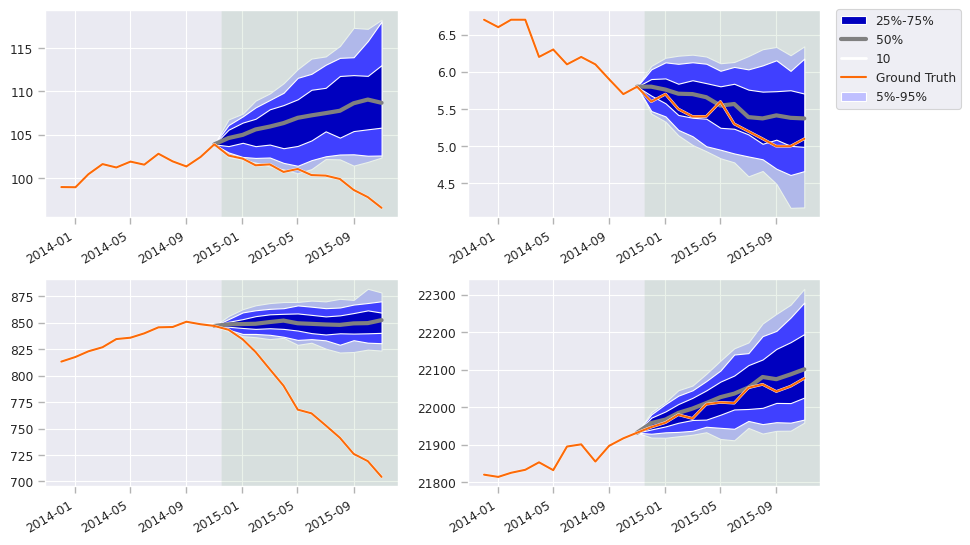

In [14]:
plot_four_forecasts(
    forecasts=forecasts,
    targets=targets,
    selection=[(0, 10), (0, 20), (0, 30), (0, 40)],
    tick_freq="4 months end",
    history_length=forecasting_estimator.history_length,
)

Visualize the inter-timestep and inter-series correlations captured by the model in its predictions.

In [28]:
# Visualize the correalation
corrcoef_v = 0
corrcoef_ts = 0

for i, (target, forecast) in enumerate(zip(targets, forecasts)):
    samples = forecast.samples

    for v in range(samples.shape[2]):
        spl = samples[:, :, v].transpose()
        corrcoef_ts = corrcoef_ts + np.corrcoef(spl)

    for ts in range(samples.shape[1]):
        spl = samples[:, ts, :].transpose()
        corrcoef_v = corrcoef_v + np.corrcoef(spl)

corrcoef_ts /= (len(targets) * 107)
corrcoef_v /= (len(targets) * 12)

plt.figure()
svm = sns.heatmap(corrcoef_ts, robust=True, center=0, xticklabels=False, yticklabels=False)
plt.title("Correlations between timesteps")

plt.figure()
svm = sns.heatmap(corrcoef_v, robust=True, center=0, xticklabels=False, yticklabels=False)
plt.title("Correlations between series")

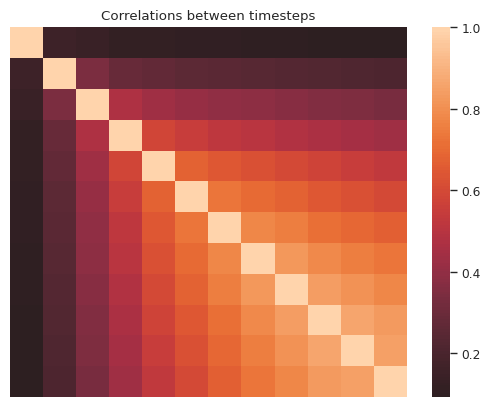

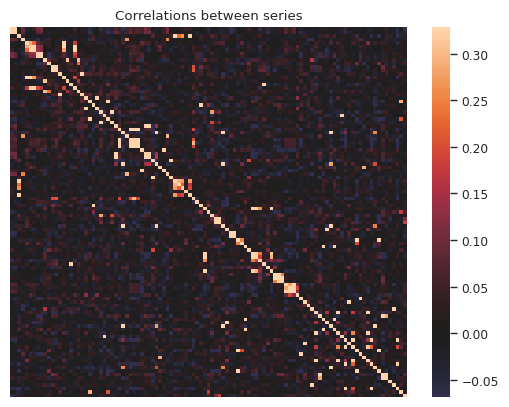

In [29]:
plot_matrices(targets, forecasts)

## Interpolation with the same model

We now demonstrate how to perform interpolation with TACTiS. For interpolation, the only change when initializing the model is to set `experiment_mode` to `interpolation`.

In [45]:
interpolation_estimator = TACTiSEstimator(
    model_parameters = {
        "flow_series_embedding_dim": 5,
        "copula_series_embedding_dim": 5,
        "flow_input_encoder_layers": 2,
        "copula_input_encoder_layers": 2,
        "input_encoding_normalization": True,
        "data_normalization": "standardization",
        "loss_normalization": "series",
        "bagging_size": 20,
        "positional_encoding":{
            "dropout": 0.0,
        },
        "flow_temporal_encoder":{
            "attention_layers": 2,
            "attention_heads": 1,
            "attention_dim": 16,
            "attention_feedforward_dim": 16,
            "dropout": 0.0,
        },
        "copula_temporal_encoder":{
            "attention_layers": 2,
            "attention_heads": 1,
            "attention_dim": 16,
            "attention_feedforward_dim": 16,
            "dropout": 0.0,
        },
        "copula_decoder":{
            "min_u": 0.05,
            "max_u": 0.95,
            "attentional_copula": {
                "attention_heads": 3,
                "attention_layers": 1,
                "attention_dim": 8,
                "mlp_layers": 2,
                "mlp_dim": 48,
                "resolution": 20,
                "activation_function": "relu"
            },
            "dsf_marginal": {
                "mlp_layers": 2,
                "mlp_dim": 48,
                "flow_layers": 2,
                "flow_hid_dim": 8,
            },
        },
        "experiment_mode": "interpolation"
    },
    num_series = train_data.list_data[0]["target"].shape[0],
    history_length = history_factor * metadata.prediction_length,
    prediction_length = metadata.prediction_length,
    freq = metadata.freq,
    trainer = TACTISTrainer(
        epochs_phase_1 = 50, #50
        epochs_phase_2 = 50, #50
        batch_size = 256,
        num_batches_per_epoch = 512,
        learning_rate = 1e-3,
        weight_decay = 1e-4,
        maximum_learning_rate = 1e-3,
        clip_gradient = 1e3,
        device = torch.device("cuda:3"),
    ),
    cdf_normalization = False,
    num_parallel_samples = 100,
)

Checkpoints will not be saved


Train the model.

In [46]:
interpolation_model = interpolation_estimator.train(train_data, val_data)

Start epoch: 0
Total epochs: 100
Epochs: 100
Flow loss weight: 1.0
Copula loss weight: 0.0
Epoch: 0 / 100
Training...
Total number of training batches: 50
Epoch: 0 Average training loss: 18.89382553100586
Validation...
Creating a validation dataloader with a batch size of 256
Epoch: 0 Average validation loss: 15.168294906616211
Epochs since best epoch: 0
Epoch: 1 / 100
Training...
Total number of training batches: 50
Epoch: 1 Average training loss: 15.79802131652832
Validation...
Creating a validation dataloader with a batch size of 256
Epoch: 1 Average validation loss: 14.988149642944336
Epochs since best epoch: 0
Epoch: 2 / 100
Training...
Total number of training batches: 50
Epoch: 2 Average training loss: 13.79569149017334
Validation...
Creating a validation dataloader with a batch size of 256
Epoch: 2 Average validation loss: 12.245781898498535
Epochs since best epoch: 0
Epoch: 3 / 100
Training...
Total number of training batches: 50
Epoch: 3 Average training loss: 10.845401763916

Epoch: 31 Average training loss: 6.1987690925598145
Validation...
Creating a validation dataloader with a batch size of 256
Epoch: 31 Average validation loss: 8.269674301147461
Epochs since best epoch: 6
Epoch: 32 / 100
Training...
Total number of training batches: 50
Epoch: 32 Average training loss: 6.102959156036377
Validation...
Creating a validation dataloader with a batch size of 256
Epoch: 32 Average validation loss: 9.499394416809082
Epochs since best epoch: 7
Epoch: 33 / 100
Training...
Total number of training batches: 50
Epoch: 33 Average training loss: 6.139725208282471
Validation...
Creating a validation dataloader with a batch size of 256
Epoch: 33 Average validation loss: 8.676340103149414
Epochs since best epoch: 8
Epoch: 34 / 100
Training...
Total number of training batches: 50
Epoch: 34 Average training loss: 6.173415660858154
Validation...
Creating a validation dataloader with a batch size of 256
Epoch: 34 Average validation loss: 8.237836837768555
Epochs since best e

Epoch: 50 Average training loss: 0.005073954816907644
Validation...
Creating a validation dataloader with a batch size of 256
Epoch: 50 Average validation loss: -0.006183653604239225
Epochs since best epoch: 1
Epoch: 51 / 100
Training...
Total number of training batches: 50
Epoch: 51 Average training loss: -0.0008593827369622886
Validation...
Creating a validation dataloader with a batch size of 256
Epoch: 51 Average validation loss: 0.017883045598864555
Epochs since best epoch: 2
Epoch: 52 / 100
Training...
Total number of training batches: 50
Epoch: 52 Average training loss: -0.0022714638616889715
Validation...
Creating a validation dataloader with a batch size of 256
Epoch: 52 Average validation loss: -0.010996722616255283
Epochs since best epoch: 3
Epoch: 53 / 100
Training...
Total number of training batches: 50
Epoch: 53 Average training loss: -0.005112508311867714
Validation...
Creating a validation dataloader with a batch size of 256
Epoch: 53 Average validation loss: 0.02143228

Epoch: 81 Average training loss: -5.139936447143555
Validation...
Creating a validation dataloader with a batch size of 256
Epoch: 81 Average validation loss: -5.515967845916748
Epochs since best epoch: 1
Epoch: 82 / 100
Training...
Total number of training batches: 50
Epoch: 82 Average training loss: -5.1178460121154785
Validation...
Creating a validation dataloader with a batch size of 256
Epoch: 82 Average validation loss: -5.1566667556762695
Epochs since best epoch: 2
Epoch: 83 / 100
Training...
Total number of training batches: 50
Epoch: 83 Average training loss: -5.215284824371338
Validation...
Creating a validation dataloader with a batch size of 256
Epoch: 83 Average validation loss: -5.391739845275879
Epochs since best epoch: 3
Epoch: 84 / 100
Training...
Total number of training batches: 50
Epoch: 84 Average training loss: -5.212692737579346
Validation...
Creating a validation dataloader with a batch size of 256
Epoch: 84 Average validation loss: -5.396353721618652
Epochs sin

Get the test data for interpolation. We need to employ a hack here to make interpolation work with GluonTS based evaluation functions.

In [47]:
# Interpolation hack to work with GluonTS
_, _ ,_ , test_data = generate_dataset("fred_md", history_factor+1)
interpolation_estimator.history_length = (history_factor+1) * metadata.prediction_length

/home/toolkit/.conda/envs/tactis/lib/python3.10/site-packages/gluonts/dataset/multivariate_grouper.py:106: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  timestamp + (len(data[FieldName.TARGET]) - 1) * timestamp.freq,
/home/toolkit/.conda/envs/tactis/lib/python3.10/site-packages/gluonts/dataset/multivariate_grouper.py:108: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self.frequency = timestamp.freq
/home/toolkit/.conda/envs/tactis/lib/python3.10/site-packages/gluonts/dataset/multivariate_grouper.py:217: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  freq=data[FieldName.START].freq,
/home/toolkit/.conda/envs/tactis/lib/python3.10/site-packages/gluonts/dataset/multivariate_grouper.py:166: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  freq=data[FieldName.START].freq,
/home/toolkit/.conda/envs/tactis/lib/python3.10/site-packages/

Create the predictor. Note that some of the arguments may differ from the predictor created for forecasting.

In [48]:
# Enable copula in the model_parameters since the copula is now trained
# This needs to be done again here since a 
# TACTiSPredictionNetwork is created for inference from the `model_parameters`
interpolation_estimator.model_parameters["skip_copula"] = False

# Create predictor
transformation = interpolation_estimator.create_transformation()
device = interpolation_estimator.trainer.device
interpolation_predictor = interpolation_estimator.create_predictor(
    transformation=transformation,
    trained_network=interpolation_model,
    device=device,
    experiment_mode="interpolation",
    history_length=interpolation_estimator.history_length,
)

Obtain the metrics on the test dataset. Also obtain the samples and ground truth values for plotting them.

In [49]:
interpolation_predictor.batch_size = 16
interpolation_metrics, interpolation_ts_wise_metrics, predictions, targets = compute_validation_metrics_interpolation(
    predictor=interpolation_predictor,
    dataset=test_data,
    window_length=interpolation_estimator.history_length,
    prediction_length=interpolation_estimator.prediction_length,
    num_samples=100,
    return_forecasts_and_targets=True,
    split=True
)

Using batch size: 16


Plot the obtained interpolations along with the ground truth values.


In [50]:
def plot_single_series(samples, all_targets, prediction_timesteps, all_timesteps):
    """
    Shapes:
    samples: (pred_len, num_samples)
    all_targets: (pred_len + hist_len, )
    prediction_timesteps: (pred_len,)
    all_timesteps: (pred_len + hist_len, )
    """
    plt.figure()
    
    for zorder, quant, color, label in [
        [1, 0.05, (0.75,0.75,1), "5%-95%"],
        [2, 0.10, (0.25,0.25,1), "10%-90%"],
        [3, 0.25, (0,0,0.75), "25%-75%"],
    ]:
        plt.fill_between(
            prediction_timesteps,
            np.quantile(samples, quant, axis=1),
            np.quantile(samples, 1 - quant, axis=1),
            facecolor=color,
            interpolate=True,
            label=label,
            zorder=zorder,
        )
    
    plt.plot(
        prediction_timesteps,
        np.quantile(samples, 0.5, axis=1),
        color=(0.5,0.5,0.5),
        linewidth=3,
        label="50%",
        zorder=4,
    )
    
    plt.plot(all_timesteps, all_targets, color=(0, 0, 0), linewidth=2, zorder=5, label="ground truth")
    
    xmin = prediction_timesteps[0]  # Hardcoded to have the same for both subplots
    xmax = prediction_timesteps[-1]  # Go to the right-end of the plot
    plt.axvspan(xmin=xmin, xmax=xmax, facecolor=(0.2,0.5,0.2), alpha=0.1)
    
    handles, labels = plt.gca().get_legend_handles_labels()
    order = [1, 2, 3, 4, 0]
    plt.legend([handles[idx] for idx in order], [labels[idx] for idx in order])
    
    plt.show()

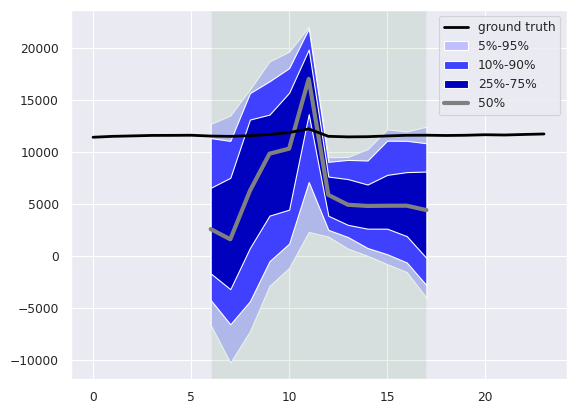

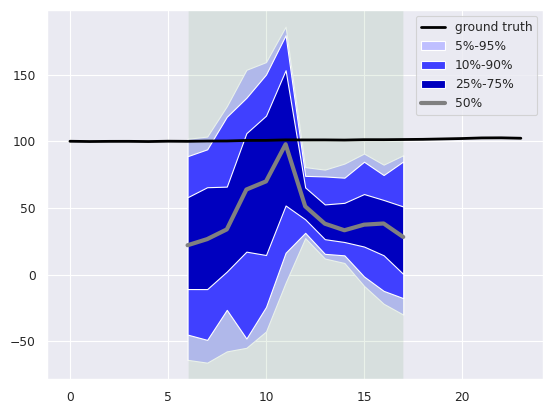

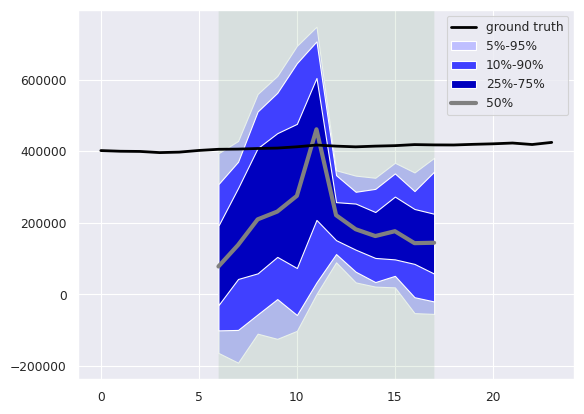

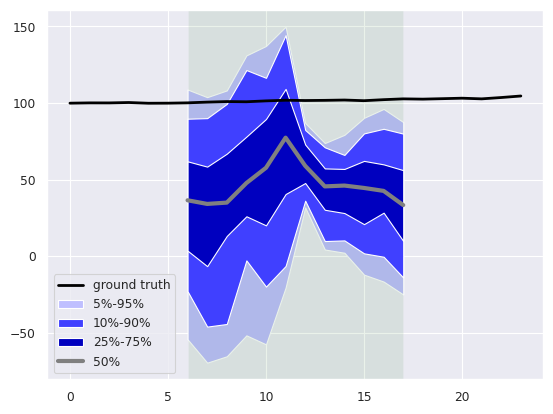

In [51]:
num_series_to_plot = 4

history_length = interpolation_estimator.history_length
prediction_length = interpolation_estimator.prediction_length


for i in range(1, num_series_to_plot+1):
    # Get the ith prediction. This could be randomized
    samples = np.array(predictions[i].samples.transpose(2, 1, 0)[i])
    # Get the history and prediction windows from the `targets` array
    # For interpolation history_length itself is the total history_length and prediction_length
    ground_truth_full = np.array(targets[i].iloc[-history_length:, i])
    
    num_timesteps_observed_on_each_side = (history_length - prediction_length) // 2
    prediction_timesteps_start = num_timesteps_observed_on_each_side
    prediction_timesteps_end = prediction_timesteps_start + prediction_length
    prediction_timesteps = np.array(range(prediction_timesteps_start, prediction_timesteps_end))                                           
    timesteps_full = np.array(range(0, history_length))
                              
    plot_single_series(samples, ground_truth_full, prediction_timesteps, timesteps_full)

# Section 2

This section explains some key details about the TACTiS architecture. We use the latest [TACTiS-2](https://arxiv.org/abs/2310.01327) model.

### TACTiS

TACTiS is an **encoder-decoder** model similar to standard transformers. Our main contribution, attentional copulas, belongs to the decoder. However, both component have key features that enables the great flexibility of TACTiS. Let’s dive into these!

<img src="images/tactis-2-architecture.png" alt="Architecture of TACTiS-2" />

### What gives TACTiS its flexibility?

**The TACTiS encoder** treats each point in each time series ($x_{ij}$) as a distinct time-stamped token, along with a mask value ($m_{ij}$) that indicates where the point is observed or masked. The points which are masked are predicted based on those observed. For each point, we can specify additional covariates ($c_{ij}$) to provide additional context. It is the pattern of missing values themselves—namely, where they are located with respect to measured values—that determines whether it performs forecasting, interpolation, or another similar task. Consequently, TACTiS naturally supports changes in its inputs, such as the unavailability of some time series, and in its outputs, such as changes in forecast horizon. TACTiS also inherently supports misalignment and differences in sampling frequencies, since each point in the time series is encoded as a token separately from the others.

### How does TACTiS model forecast distributions?

TACTiS considers the general problem of estimating the joint distribution of missing values (i.e., $m_{ij} = 0$), given the observed ones ($m_{ij} = 1)$, the covariates, and the timestamps: 

$$    P\Big(
        X^{(m)}
        \mathrel{\Big|}
        X^{(o)}, \mathbf{C}^{(m)}, \mathbf{C}^{(o)}, \mathbf{T}^{(m)}, \mathbf{T}^{(o)}
    \Big),
$$
where $\mathbf{X}^{(m)} = [X_{11}, \ldots, X_{1, l_1}; \ldots; X_{n1}, \ldots, X_{n, l_n} \mid m_{ij} = 0]$ is a random vector containing the $d$ random variables $X_{ij}$ corresponding to all missing values, $\mathbf{X}^{(o)}$ is the same, but for observed values. $\mathbf{C}^{(m)}$, $\mathbf{C}^{(o)}$, $\mathbf{T}^{(m)}$, $\mathbf{T}^{(o)}$ correspond to identical partitionings of the covariates and timestamps, respectively.

**The TACTiS decoder** breaks down the modelling of the distribution into marginals and a copula.

Informally, a copula is a mathematical construct that expresses the coupling (dependency structure) of multiple random variables, irrespective of their marginal distributions (appearance). 

To model the joint distribution, TACTiS introduces attentional copulas, which are non-parameteric copula based density estimators. TACTiS uses a two-stage optimization procedure that first optimizes the parameters of the marginals, and then optimizes the parameters of the copula. We show in our paper that any non-parametric copula learned using our approach is valid, i.e. it satisfies the mathematical definition of a copula. We refer the reader to the paper for the theorems and their proofs.